In [4]:
import argparse
from configparser import ConfigParser
from importlib import import_module
import torch
import pandas as pd
import albumentations as A
import numpy as np
from tqdm import tqdm
import os
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from dataset import CustomDataLoader
from utils import collate_fn
from augmentation import get_validation_augmentation, get_preprocessing
from matplotlib import pyplot as plt


config = ConfigParser()
config.read('./configs/config.ini')

['./configs/config.ini']

In [5]:
dataset_path = config.get('path', 'dataset_path')
test_path = os.path.join(dataset_path,'train_all.json')
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_name = config.get('model','encoder_name')
encoder_weight = config.get('model','encoder_weight')
architecture = config.get('model','architecture')
preprocessing = config.getboolean('hyper_params', 'preprocessing')

model = getattr(import_module("segmentation_models_pytorch"),architecture) 

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, encoder_weight)


model = model(
    encoder_name=encoder_name, 
    encoder_weights=encoder_weight,
    in_channels=3,
    classes=11
)
test_transform = get_validation_augmentation()
test_dataset = CustomDataLoader(data_dir='/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/clothing_val.json', mode='train', transform=test_transform, preprocessing=get_preprocessing(preprocessing_fn) if preprocessing else False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=1,
                                        num_workers=4,
                                        collate_fn=collate_fn)
model_path = '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/saved/aug10/best_mIoU.pt'
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

size = 256
transform = A.Compose([A.Resize(size,size)])
print('Start prediction')

model.eval()

file_name_list = []
preds_array = np.empty((0, size*size), dtype=np.long)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Start prediction


In [3]:
images = []
img_outs = []
img_masks = []
with torch.no_grad():
    for step, (imgs, masks, image_infos) in enumerate(test_loader):
        model = model.to(device)
        outs = model(torch.stack(imgs).to(device).float())
        oms = torch.argmax(outs, dim=1).detach().cpu()
        images.append(imgs[0].detach().cpu().numpy().transpose(1,2,0))
        img_outs.append(oms.numpy())
        img_masks.append(masks[0].detach().cpu().numpy())

Traceback (most recent call last):
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 321, in reduce_storage
    fd, size = storage._share_fd_()
RuntimeError: unable to write to file </torch_9217_4174835237>
Traceback (most recent call last):
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/opt/conda/envs/segmentation/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 321, in reduce_storage
    fd, size = storage._share_fd_

RuntimeError: DataLoader worker (pid 9220) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [6]:
def compare(idx):
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    axes[0].imshow(images[idx])
    axes[1].imshow(img_outs[idx].squeeze())
    axes[2].imshow(img_masks[idx])

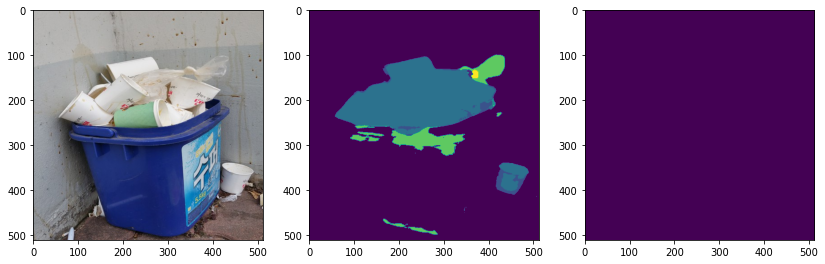

In [8]:
compare(16)